<a href="https://colab.research.google.com/github/Witcape/Emotion_Recognition_in_Live_Video_Data/blob/main/Emotion_Recognition_in_Video_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all the required libraries
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sklearn
import tensorflow as tf
import pandas as pd
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear,relu,sigmoid
import cv2
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
model = Sequential(
    [
        tf.keras.Input(shape = (5,)),
        Dense(25, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(1, activation = 'linear')
    ]
)


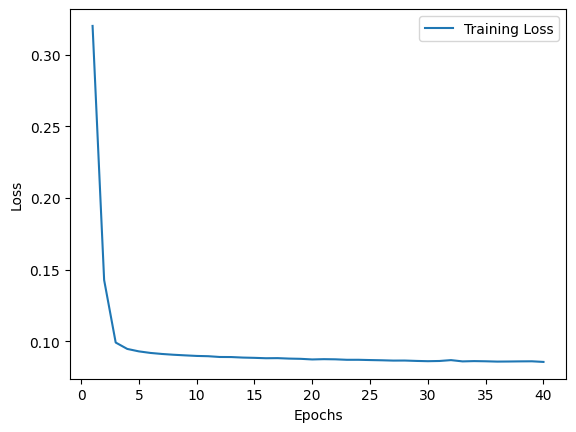

In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_data_directory = '/content/gdrive/MyDrive/Human emotions/train'
test_data_directory = '/content/gdrive/MyDrive/Human emotions/test'

In [ ]:
def load_and_preprocess_images(directory):
    images = []
    labels = []
    for emotion_label in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion_label)
        for image_file in os.listdir(emotion_dir):
            image_path = os.path.join(emotion_dir, image_file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(emotion_label)
    images = np.array(images)
    labels = np.array(labels)
    images = images / 255.0

    label_encoder = LabelEncoder()
    integer_labels = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_labels = onehot_encoder.fit_transform(integer_labels.reshape(-1, 1))

    return images, onehot_labels

X_train, y_train = load_and_preprocess_images(train_data_directory)

X_test, y_test = load_and_preprocess_images(test_data_directory)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Using **tf.keras.utils.image_dataset_from_directory** italicised textinstead of manually segregating labels and images

In [25]:
train_data_dir = '/content/gdrive/MyDrive/Human emotions/train'
test_data_dir = '/content/gdrive/MyDrive/Human emotions/test'

In [41]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir)
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir)

Found 29031 files belonging to 7 classes.
Found 7378 files belonging to 7 classes.


In [42]:
train_data_iterator = train_data.as_numpy_iterator()
test_data_iterator = test_data.as_numpy_iterator()

In [43]:
train_batch = train_data_iterator.next()
test_batch = test_data_iterator.next()

In [44]:
test_batch

(array([[[[247., 247., 247.],
          [247., 247., 247.],
          [247., 247., 247.],
          ...,
          [245., 245., 245.],
          [245., 245., 245.],
          [245., 245., 245.]],
 
         [[247., 247., 247.],
          [247., 247., 247.],
          [247., 247., 247.],
          ...,
          [245., 245., 245.],
          [245., 245., 245.],
          [245., 245., 245.]],
 
         [[247., 247., 247.],
          [247., 247., 247.],
          [247., 247., 247.],
          ...,
          [245., 245., 245.],
          [245., 245., 245.],
          [245., 245., 245.]],
 
         ...,
 
         [[ 17.,  17.,  17.],
          [ 17.,  17.,  17.],
          [ 17.,  17.,  17.],
          ...,
          [ 20.,  20.,  20.],
          [ 20.,  20.,  20.],
          [ 20.,  20.,  20.]],
 
         [[ 17.,  17.,  17.],
          [ 17.,  17.,  17.],
          [ 17.,  17.,  17.],
          ...,
          [ 20.,  20.,  20.],
          [ 20.,  20.,  20.],
          [ 20.,  20.,  20.

In [45]:
len(test_batch)

2

In [46]:
train_batch[0].shape

(32, 256, 256, 3)

In [47]:
train_data = train_data.map(lambda x,y: (x/255,y))
test_data = test_data.map(lambda x,y: (x/255,y))

In [63]:
scaled_train_iterator = train_data.as_numpy_iterator()
scaled_test_iterator = test_data.as_numpy_iterator()
train_batch = scaled_train_iterator.next()
test_batch = scaled_test_iterator.next()
test_batch[0].max()

1.0

In [64]:
len(train_data)

908

In [65]:
train_size = int(len(train_data)*0.8)
val_size = int(len(train_data)*0.2)+1
test_size = len(test_data)
print(train_size , val_size)

726 182


In [66]:
train = train_data.take(train_size)
val = train_data.skip(train_size).take(val_size)
test = test_data.take(test_size)

In [67]:
print(len(train),len(val),len(test))

726 182 231
